In [70]:
import pandas as pd
import matplotlib.pyplot as plt
import transformers
import seaborn as sns
import numpy as np

from transformers import AutoTokenizer, AutoModel, AutoConfig, DataCollatorWithPadding
from datasets import load_dataset
from torch.utils.data import DataLoader
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score

In [33]:
pd.set_option('display.max_colwidth', None)

# Sentiment Analysis using emotion dataset

## Load the data and take a look at it

In [34]:
emotions_ds = load_dataset("emotion")

No config specified, defaulting to: emotion/split
Found cached dataset emotion (/Users/davidbreinl/.cache/huggingface/datasets/emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd)


  0%|          | 0/3 [00:00<?, ?it/s]

In [35]:
emotions_ds

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [36]:
class_names = emotions_ds["train"].features["label"].names
class_names

['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

In [37]:
emotions_ds.set_format("pandas")

In [38]:
emotions_ds_train_pandas = emotions_ds["train"][:]

In [39]:
emotions_ds_train_pandas

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplace i will know that it is still on the property,2
4,i am feeling grouchy,3
...,...,...
15995,i just had a very brief time in the beanbag and i said to anna that i feel like i have been beaten up,0
15996,i am now turning and i feel pathetic that i am still waiting tables and subbing with a teaching degree,0
15997,i feel strong and good overall,1
15998,i feel like this was such a rude comment and im glad that t,3


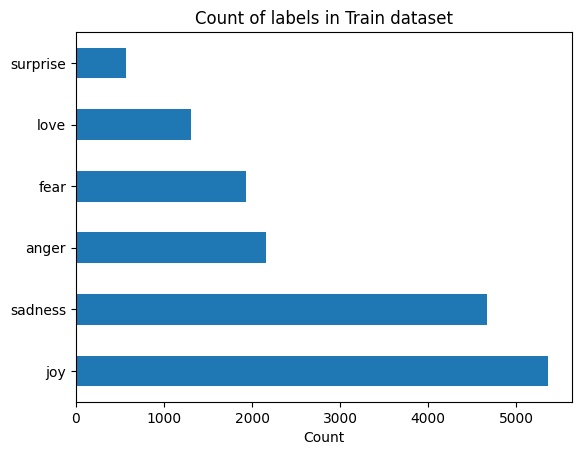

In [40]:
# As we can see we are dealing with an imbalanced dataset -> we need to take this into account when training our model (Accuracy probably not a good metric)

emotions_ds_train_pandas["label_names"] = [class_names[idx] for idx in emotions_ds["train"][:]["label"]]
emotions_ds_train_pandas["label_names"].value_counts().plot.barh()
plt.title("Count of labels in Train dataset")
plt.xlabel("Count")
plt.show()

In [41]:
emotions_ds_train_pandas["text"][0].split(" ")

['i', 'didnt', 'feel', 'humiliated']

In [42]:
emotions_ds_train_pandas["tweet_word_count"] = [len(tweet.split(" ")) for tweet in emotions_ds_train_pandas["text"]]

<AxesSubplot: xlabel='label_names', ylabel='tweet_word_count'>

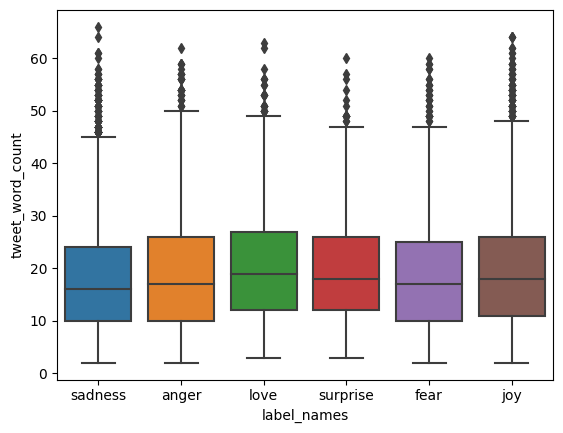

In [43]:
sns.boxplot(x="label_names", y="tweet_word_count", data=emotions_ds_train_pandas)

## Creating baseline without solving class imbalence problem

### Lets Encode the data

In [44]:
emotions_ds.reset_format()

In [45]:
MODEL_CHKPT = "distilbert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(MODEL_CHKPT)

tokenizer("this is a test in order to see if the encoder is working", return_tensors="pt")

{'input_ids': tensor([[  101,  2023,  2003,  1037,  3231,  1999,  2344,  2000,  2156,  2065,
          1996,  4372, 16044,  2099,  2003,  2551,   102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [46]:
# We first have to define a function that we can then apply onto our entire huggingface dataset
def tokenize_batch(batch):
    return tokenizer(batch["text"], 
                     padding=True,
                     truncation=True,
                     add_special_tokens=True,
                     return_tensors="pt")

# Lets check if the function is actually working
tokenize_batch(emotions_ds["train"][:2])

{'input_ids': tensor([[  101,  1045,  2134,  2102,  2514, 26608,   102,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0],
        [  101,  1045,  2064,  2175,  2013,  3110,  2061, 20625,  2000,  2061,
          9636, 17772,  2074,  2013,  2108,  2105,  2619,  2040, 14977,  1998,
          2003,  8300,   102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [47]:
tweets_encoded = emotions_ds.map(tokenize_batch, batched=True, batch_size=None) #batch_size NONE!!!!!!!! Very important since else our tokens are in different lengths
tweets_encoded # as we can see we now included the input ids and the attention mask

Loading cached processed dataset at /Users/davidbreinl/.cache/huggingface/datasets/emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd/cache-adf5e58498032292.arrow
Loading cached processed dataset at /Users/davidbreinl/.cache/huggingface/datasets/emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd/cache-5c21202645d89d6a.arrow
Loading cached processed dataset at /Users/davidbreinl/.cache/huggingface/datasets/emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd/cache-918c84ec8ab24327.arrow


DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
})

In [48]:
# We can see that all of our input_ids in the training set have the same length -> thats what we want
set([len(item) for item in tweets_encoded["train"]["input_ids"]])

{87}

In [49]:
# since our pytorch model will expect us to input torch tensors lets switch the format
tweets_encoded.set_format("torch",
                          columns=["input_ids", "attention_mask", "label"])

In [50]:
# Lets take a look at the first two examples
tweets_encoded["train"][:2]

{'label': tensor([0, 0]),
 'input_ids': tensor([[  101,  1045,  2134,  2102,  2514, 26608,   102,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0],
         [  101,  1045,  2064,  2175,  2013,  3110,  2061, 20625,  2000,  2061,
           9636, 17772,  2074,  2013,  2108,  2105,  2619,  2040, 14977,  1998,
           2003,  8300,   102,     0,     0,     0,     0,     0,     0,     0,
              0,     

In [51]:
# Define a datacollator that will assist us in stacking out tensors and making sure that each batch gets padded to the maximum length
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

### Define Dataloaders for our PyTorch Model

In [52]:
BATCH_SIZE=32

train_dataloader= DataLoader(tweets_encoded["train"], batch_size=BATCH_SIZE, shuffle=True, collate_fn=data_collator)
val_dataloader= DataLoader(tweets_encoded["validation"], batch_size=BATCH_SIZE, shuffle=False, collate_fn=data_collator)

In [53]:
# Lets check if the dataloaders are ready to go
train_dataloader, val_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7f919a38e2c0>,
 <torch.utils.data.dataloader.DataLoader at 0x7f919a38eb00>)

In [54]:
# Lets check out the first batch inside of our train_dataloader
next(iter(train_dataloader))

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'input_ids': tensor([[ 101, 1045, 2514,  ...,    0,    0,    0],
        [ 101, 1045, 2018,  ...,    0,    0,    0],
        [ 101, 1045, 2514,  ...,    0,    0,    0],
        ...,
        [ 101, 1045, 2371,  ...,    0,    0,    0],
        [ 101, 1045, 3984,  ...,    0,    0,    0],
        [ 101, 1045, 2031,  ...,    0,    0,    0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'labels': tensor([1, 0, 4, 0, 0, 1, 0, 5, 1, 1, 0, 3, 1, 0, 3, 0, 0, 0, 3, 0, 1, 2, 1, 4,
        4, 4, 4, 1, 1, 0, 1, 4])}

### Lets now train our finetuned baseline model

In [55]:
from app.modeling.model import TweetClassificationModel
from app.modeling.train import Model_training
import torch
from transformers import get_scheduler
from app.modeling.utils.model_utils import EarlyStopper

In [24]:
model = AutoModel.from_pretrained(MODEL_CHKPT)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [25]:
AutoConfig.from_pretrained(MODEL_CHKPT)

DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.27.3",
  "vocab_size": 30522
}

In [26]:
# Lets now import our custom finetunded model
model = TweetClassificationModel(checkpoint=MODEL_CHKPT, num_classes=len(class_names))

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [27]:
# Lets also use our custom trainer class
trainer = Model_training(model=model, device=torch.device("mps"))

In [28]:
early_stopper = EarlyStopper(patience=0)
optimizer=torch.optim.AdamW(model.parameters(), lr=1e-5)

In [29]:
torch.manual_seed(42)

results = trainer.train(train_dataloader=train_dataloader,
              eval_dataloader=val_dataloader,
              optimizer=optimizer,
              epochs=5,
              early_stopper=early_stopper,
              model_save_name="distilbert-base-finetuned-for-tweet-classification"
              )

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1, Current LR: 1e-05:
Train Loss: 0.70193 | Train F1: 0.70908 | Train Acc: 0.74562
Validation Loss: 0.27287 | Validation F1: 0.90013 | Validation Acc: 0.90278



 20%|██        | 1/5 [04:04<16:17, 244.44s/it]

Epoch 2, Current LR: 1e-05:
Train Loss: 0.18720 | Train F1: 0.92461 | Train Acc: 0.92594
Validation Loss: 0.18010 | Validation F1: 0.92642 | Validation Acc: 0.92460



 40%|████      | 2/5 [08:07<12:11, 243.69s/it]

Epoch 3, Current LR: 1e-05:
Train Loss: 0.12678 | Train F1: 0.94509 | Train Acc: 0.94575
Validation Loss: 0.16631 | Validation F1: 0.92570 | Validation Acc: 0.92560



 60%|██████    | 3/5 [12:10<08:06, 243.16s/it]

Epoch 4, Current LR: 1e-05:
Train Loss: 0.10335 | Train F1: 0.95247 | Train Acc: 0.95263
Validation Loss: 0.15643 | Validation F1: 0.93451 | Validation Acc: 0.93601



 80%|████████  | 4/5 [20:11<05:02, 302.97s/it]

Epoch 5, Current LR: 1e-05:
Train Loss: 0.08946 | Train F1: 0.95945 | Train Acc: 0.95956
Validation Loss: 0.16327 | Validation F1: 0.93266 | Validation Acc: 0.93204

Stopping Training..


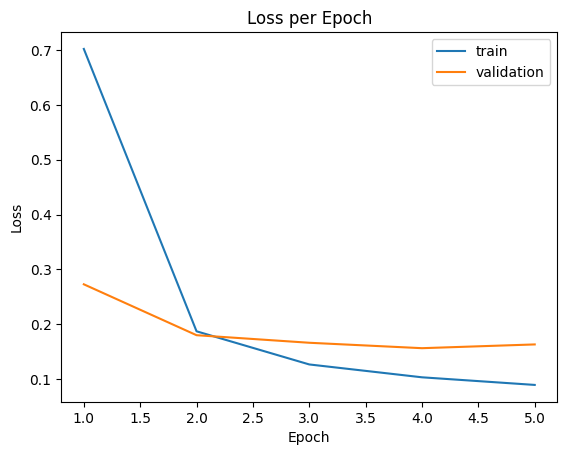

In [112]:
epochs = list(range(1,6))

plt.plot(epochs, results["train_loss"], label="train")
plt.plot(epochs, results["val_loss"], label="validation")
plt.legend()
plt.title("Loss per Epoch")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.show()

### Evaluate the baseline model

In [56]:
from app.modeling.model import TweetClassificationModel

In [57]:
trained_model = TweetClassificationModel(MODEL_CHKPT, len(class_names))

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [58]:
trained_model.load_state_dict(torch.load("app/modeling/models/distilbert-base-finetuned-for-tweet-classification.pth"))

<All keys matched successfully>

In [59]:
trained_model = trained_model.to(torch.device("mps"))

In [60]:
from torch import nn
from torch.nn.functional import cross_entropy

In [61]:
def forward_pass_with_label(batch):
    with torch.inference_mode():

        inputs = {k:v.to(torch.device("mps")) for k,v in batch.items() if k in tokenizer.model_input_names}

        output = trained_model(input_ids = inputs["input_ids"],
                       attention_mask = inputs["attention_mask"],
                       labels=None)

        pred_label = torch.argmax(output["logits"], dim=1)

        loss = cross_entropy(input=output.logits, target=batch["label"].to(torch.device("mps")), reduction="none")

    return {
        "loss": loss.cpu().numpy(),
        "predicted_label": pred_label.cpu().numpy()
    }

In [62]:
tweets_encoded["test"] = tweets_encoded["test"].map(forward_pass_with_label, batched=True, batch_size=16)

/Users/davidbreinl/opt/anaconda3/envs/mlenv/lib/python3.10/site-packages/torch/_tensor_str.py:115: UserWarning: The operator 'aten::nonzero' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1666646991213/work/aten/src/ATen/mps/MPSFallback.mm:11.)
  nonzero_finite_vals = torch.masked_select(


Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [63]:
tweets_encoded.set_format("pandas")

In [64]:
# Lets look at the texts with the largest losses -> model had the hardest time predicting

loss_df = tweets_encoded["test"][:][["text", "label",  "loss", "predicted_label"]]
loss_df["true_label"] = [class_names[sentiment] for sentiment in loss_df["label"]]
loss_df["predicted_label"] = [class_names[sentiment] for sentiment in loss_df["predicted_label"]]

In [65]:
loss_df.sort_values("loss", ascending=False).head(30)

,text,label,loss,predicted_label,true_label
125,i feel very mislead by someone that i really really thought i knew and liked very much so,2,7.757113,anger,love
150,im feeling rather angsty and listless,0,7.246045,love,sadness
426,i feel unprotected a class post count link href http reprogramming in process,0,6.952498,fear,sadness
1382,i cannot even begin to express in words the depth of sorrow that i feel having not posted any of my ludicrous rants over the passed days,5,6.311422,sadness,surprise
816,whenever i put myself in others shoes and try to make the person happy,3,4.704782,joy,anger
1928,i feel inside cause life is like a game sometimes but then you came around me the walls just disappeared nothing to surround me and keep me from my fears im unprotected see how ive opened up youve made me trust,4,4.582371,sadness,fear
1253,i don t feel betrayed coz the backstabber had no grounds for their accusation but i m just amazed at some people s ability to do such things,5,4.572905,sadness,surprise
1431,i felt a stronger wish to be free from self cherishing through my refuge practice and a return to the feeling of freedom and protection from suffering which i stayed with for the rest of the meditation,0,4.163767,joy,sadness
290,i just feel are ludicrous and wasting space or so trite they should have looked at the book first and come up with something a little more original,5,4.060954,sadness,surprise
468,i cant help feeling this way,0,4.002155,joy,sadness


In [66]:
# Lets create a confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, accuracy_score, f1_score

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6,6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized Confusion Matrix")
    plt.show()

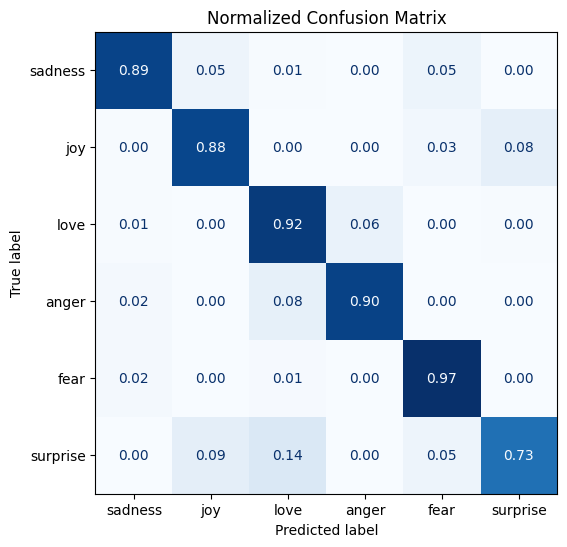

In [68]:
plot_confusion_matrix(loss_df["predicted_label"], loss_df["true_label"], labels=class_names)

In [71]:
recall = recall_score(loss_df["true_label"], loss_df["predicted_label"], average="weighted")
precision = precision_score(loss_df["true_label"], loss_df["predicted_label"], average="weighted")
accuracy = accuracy_score(loss_df["true_label"], loss_df["predicted_label"])
f1_score = f1_score(loss_df["true_label"], loss_df["predicted_label"], average="weighted")

In [73]:
pd.DataFrame({"precision": precision,
              "recall": recall,
              "f1": f1_score,
              "accuracy": accuracy}, 
              index=["distilbert-base-finetuned-for-tweet-classification"])

,precision,recall,f1,accuracy
distilbert-base-finetuned-for-tweet-classification,0.923269,0.92,0.920952,0.92


### Make some predictions on custom text

In [67]:
from app.modeling.inference import make_predictions


In [78]:
text = "It's really cool that I am now able to classify some tweets"

make_predictions(text, class_names, tokenizer, trained_model)

'joy'